generate data for time 10


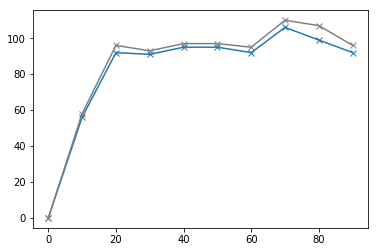

In [1]:
import pyabc
from study_abc_noise.model import MRNATranscriptionModelVars as ModelVars
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
import pickle
%matplotlib inline

# for debugging
for module in ['Distance', 'Acceptor', 'Epsilon']:
    logger = logging.getLogger(module)
    logger.setLevel(logging.DEBUG)
    fh = logging.FileHandler('log/logger_laplace.log')
    fh.setLevel(logging.DEBUG)
    logger.addHandler(fh)

arr_n_t = [3, 5, 10, 15, 30, 100]
arr_n_t = [10]

succ_prob=0.95

# create data
for n_t in reversed(arr_n_t):
    fn = f"data/data_{n_t}_{succ_prob}.p"
    mv = ModelVars(n_t=n_t, noise_success_probability=succ_prob)
    if not os.path.isfile(fn):
        print(f"generate data for time {n_t}")
        data_exact = mv.get_model()(mv.p_true)
        data = mv.add_noise_to_data(data_exact)
        pickle.dump((data_exact, data), open(fn, "wb"))
    data_exact, data = pickle.load(open(fn, "rb"))
    plt.plot(data['t'], data['mrna'], 'x-')
    plt.plot(data['t'], data_exact['mrna'], 'x-', color='grey')

In [ ]:
# proposed method

for n_t in arr_n_t:
    mv = ModelVars(n_t=n_t, noise_success_probability=succ_prob)
    fb = f"mrna_{n_t}_{succ_prob}_stochacc_v2"
    if os.path.isfile(f"{fb}.db"):
        continue
    abc = pyabc.ABCSMC(
        models=mv.get_model(),
        parameter_priors=mv.get_prior(),
        distance_function=mv.get_kernel(),
        eps=pyabc.Temperature(log_file=f"log/log_temperature_{fb}.json", schemes=[
            pyabc.AcceptanceRateScheme(), pyabc.ExpDecayFixedRatioScheme(alpha=0.75)]),
       acceptor=pyabc.StochasticAcceptor(log_file=f"log/log_acceptor_{fb}.json"),
        population_size=1000,
        sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=20, check_max_eval=True)
    )
    data = pickle.load(open(f"data/data_{n_t}_{succ_prob}.p", "rb"))[1]
    abc.new(f"sqlite:///{fb}.db", data)
    abc.run()#min_acceptance_rate=1e-4)
    print()

INFO:History:Start <ABCSMC(id=1, start_time=2019-12-30 11:45:23.153074, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=-8.5612e+01 for t=0.
DEBUG:Epsilon:Proposed temperatures for 0: [3167.2708134711866].
INFO:ABC:t: 0, eps: 3167.2708134711866.
DEBUG:Acceptor:Encountered pd=-6.6582e+01 > c=-8.5612e+01, thus weight=1.0060e+00.
DEBUG:Acceptor:Encountered pd=-7.8423e+01 > c=-8.5612e+01, thus weight=1.0023e+00.
DEBUG:Acceptor:Encountered pd=-5.9847e+01 > c=-8.5612e+01, thus weight=1.0082e+00.
DEBUG:Acceptor:Encountered pd=-8.4229e+01 > c=-8.5612e+01, thus weight=1.0004e+00.
INFO:ABC:Acceptance rate: 1000 / 3382 = 2.9568e-01, ESS=1.0000e+03.
DEBUG:Acceptor:pdf_norm=-5.9847e+01 for t=1.
DEBUG:Epsilon:Proposed temperatures for 1: [723.4998767691575, 2375.45311010339].
INFO:ABC:t: 1, eps: 723.4998767691575.
DEBUG:Acceptor:Encountered pd=-5.4135e+01 > c=-5.9847e+01, thus weight=1.0079e+00.
DEBUG:Acceptor:Encountered pd=-5.7094e+01 > c=-5.9847e+01, thus weight=1.

In [ ]:
# sequential but bad c

for n_t in arr_n_t:
    mv = ModelVars(n_t=n_t)
    fb = f"mrna_{n_t}_{succ_prob}_stochacc_badc"
    if os.path.isfile(f"{fb}.db"):
        continue
    abc = pyabc.ABCSMC(
        models=mv.get_model(),
        parameter_priors=mv.get_prior(),
        distance_function=mv.get_kernel(),
        eps=pyabc.Temperature(log_file=f"log/log_temperature_{fb}.json"),
        acceptor=pyabc.StochasticAcceptor(pdf_norm_method=pyabc.pdf_norm_from_kernel,
                                          log_file=f"log/log_acceptor_{fb}.json"),
        population_size=1000,
        sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=20, check_max_eval=True)
    )
    data = pickle.load(open(f"data/data_{n_t}_{succ_prob}.p", "rb"))[1]
    abc.new(f"sqlite:///{fb}.db", data)
    abc.run(min_acceptance_rate=1e-3)
    print()

In [ ]:
# rejection with adaptive c (in general not applicable)

for n_t in arr_n_t:
    mv = ModelVars(n_t=n_t)
    fb = f"mrna_{n_t}_{succ_prob}_rejection"
    if os.path.isfile(f"{fb}.db"):
        continue
    abc = pyabc.ABCSMC(
        models=mv.get_model(),
        parameter_priors=mv.get_prior(),
        distance_function=mv.get_kernel(),
        eps=pyabc.Temperature(log_file=f"log/log_temperature_{fb}.json"),
        acceptor=pyabc.StochasticAcceptor(log_file=f"log/log_acceptor_{fb}.json"),
        population_size=1000,
        sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=20, check_max_eval=True)
    )
    data = pickle.load(open(f"data/data_{n_t}_{succ_prob}.p", "rb"))[1]
    abc.new(f"sqlite:///{fb}.db", data)
    abc.run(max_nr_populations=1, min_acceptance_rate=1e-3)
    print()

In [ ]:
# rejection with bad (but correct) c

for n_t in arr_n_t:
    mv = ModelVars(n_t=n_t)
    fb = f"mrna_{n_t}_{succ_prob}_rejection_badc"
    if os.path.isfile(f"{fb}.db"):
        continue
    abc = pyabc.ABCSMC(
        models=mv.get_model(),
        parameter_priors=mv.get_prior(),
        distance_function=mv.get_kernel(),
        eps=pyabc.Temperature(log_file=f"log/log_temperature_{fb}.json"),
        acceptor=pyabc.StochasticAcceptor(pdf_norm_method=pyabc.pdf_norm_from_kernel,
                                          log_file=f"log/log_acceptor_{fb}.json"),
        population_size=1000,
    )
    data = pickle.load(open(f"data/data_{n_t}_{succ_prob}.p", "rb"))[1]
    abc.new(f"sqlite:///{fb}.db", data)
    abc.run(max_nr_populations=1, min_acceptance_rate=1e-3)
    print()

In [ ]:
# noisy model

for n_t in arr_n_t:
    mv = ModelVars(n_t=n_t)
    fb = f"mrna_{n_t}_{succ_prob}_noisymodel"
    if os.path.isfile(f"{fb}.db"):
        continue
    abc = pyabc.ABCSMC(
        models=mv.get_model_noisy(),
        parameter_priors=mv.get_prior(),
        distance_function=mv.get_distance(),
        population_size=1000,
        sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=20, check_max_eval=True)
    )
    data = pickle.load(open(f"data/data_{n_t}_{succ_prob}.p", "rb"))[1]
    abc.new(f"sqlite:///{fb}.db", data)
    abc.run(min_acceptance_rate=1e-3)
    print()